# Run + process percentiles

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github')
import utils

## Run percentiles.py

In [2]:
#config variables for percentiles.py
RCM = 'BARPA-R' #'CCAM-v2203-SN'
model_list = ['CMCC-ESM2', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'EC-Earth3', 'CESM2'] #MPI-ESM1-2-HR // NorESM2-MM for BARPA only and CNRM-ESM2-1 for CCAM only
model_list = model_list + ['CNRM-ESM2-1'] if RCM == 'CCAM-v2203-SN' else model_list + ['MPI-ESM1-2-HR', 'NorESM2-MM']
GWL = 1.2 #1.5 2.0 3.0
dataset_source = 'CMIP6' #AGCD  CMIP6
ssp = 'ssp370' #ssp126 ssp370

bc = 'output' #raw input output 
bc_source = 'AGCDv1' #AGCDv1 BARRAR2
bc_method = 'QME' #QME MRNBC

p_thresh = 15
accumulation = 3
percentile_grid_output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs' 
percentile_log_output_dir = '/g/data/mn51/users/jb6465/percentile_run_logs' #local for now, change to ia39 later

In [3]:
date_str = datetime.now().strftime("%Y%m%d")

In [4]:
%%time
for RCM in ['BARPA-R', 'CCAM-v2203-SN']: 
    GCM_list = os.listdir(f"/g/data/ia39/australian-climate-service/release/CORDEX/output-Adjust/CMIP6/bias-adjusted-output/AUST-05i/{'BOM' if 'BARPA' in RCM else 'CSIRO' if 'CCAM' in RCM else 'NSW-Government' if 'NARCliM' in RCM else 'UQ-DES'}")
    for GCM in GCM_list:
        for GWL in [1.2, 1.5, 2.0, 3.0]:
            if len(glob.glob(f"{percentile_grid_output_dir}/*{GCM}*{ssp}*{'BOM' if 'BARPA' in RCM else 'CSIRO' if 'CCAM' in RCM else RCM}*{GWL}*")) == 0:
                print(f"Computing {ssp}, {RCM}, {GCM}, {GWL}, {bc_method}-{bc_source} p15")
                run_command =  (
                        f"/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/bin/python /g/data/mn51/users/jb6465/drought-github/percentiles/percentiles.py"
                        f" --datasetSource={dataset_source}"
                        f" --SSP={ssp}" 
                        f" --RCM={RCM}"
                        f" --GCM={GCM}"
                        f" --GWL={GWL}"
                        f" --bc={bc}" #raw input output
                        f" --bcSource={bc_source}"
                        f" --bcMethod={bc_method}"
                        f" --percentileThreshold={p_thresh}"
                        f" --Accumulation={str(accumulation)}"
                        f" --outputDir={percentile_grid_output_dir}"
                        f" --nworkers=14" 
                        #f" >> {percentile_log_output_dir}/percentile.py_run_log_{date_str}_{GCM}_{RCM}.txt 2>&1"
                        )
                os.system(run_command)
                       

Computing ssp370, CCAM-v2203-SN, NorESM2-MM, 1.2, QME-AGCDv1 p15
Dask dashboard is available at: /proxy/8787/status
========= CCAM-v2203-SN_NorESM2-MM =========
Computing /g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_NorESM2-MM_ssp370_r1i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCDv1-1960-2022.nc...
Computing ssp370, CCAM-v2203-SN, NorESM2-MM, 1.5, QME-AGCDv1 p15min 44.6s
Dask dashboard is available at: /proxy/8787/status
========= CCAM-v2203-SN_NorESM2-MM =========
Computing /g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_NorESM2-MM_ssp370_r1i1p1f1_CSIRO_v1-r1_GWL1.5_ACS-QME-AGCDv1-1960-2022.nc...
Computing ssp370, CCAM-v2203-SN, NorESM2-MM, 2.0, QME-AGCDv1 p15min 45.1s
Dask dashboard is available at: /proxy/8787/status
========= CCAM-v2203-SN_NorESM2-MM =========
Computing /g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_NorESM2-MM_ssp370_r1i

## Process percentiles.py outputs

#### SWITCHES (toggle on / off)

In [5]:
BC_SWITCH = True
AGCD_MASK_SWITCH = True

## GWL slicing

In [6]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 97afbb834254489b4bca1e82af79b45f4854676f


### 10-50-90 Percentiles for GWL and change between GWLs

In [7]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*p15*{}".format(input_dir, '.nc'))))

In [8]:
files

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.5_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL3.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1

In [10]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file] if BC_SWITCH == False else ['_'.join((file.split('/')[-1]).split('_')[-7:-3]) for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['models'] = GWL_ens_list
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}p15_3month_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file] if BC_SWITCH == False else ['_'.join((file.split('/')[-1]).split('_')[-7:-3]) for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['models'] = GWL12_ens_list
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


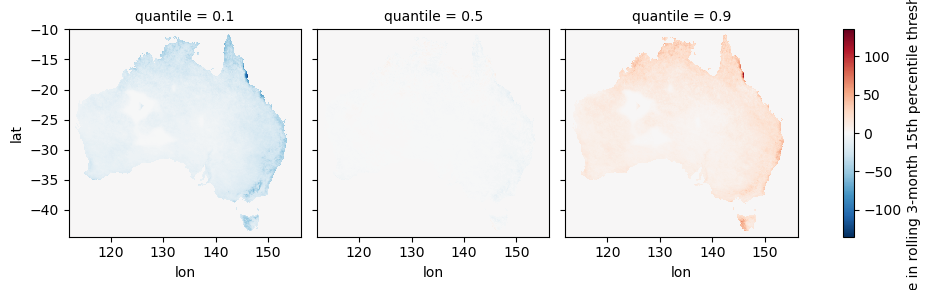

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

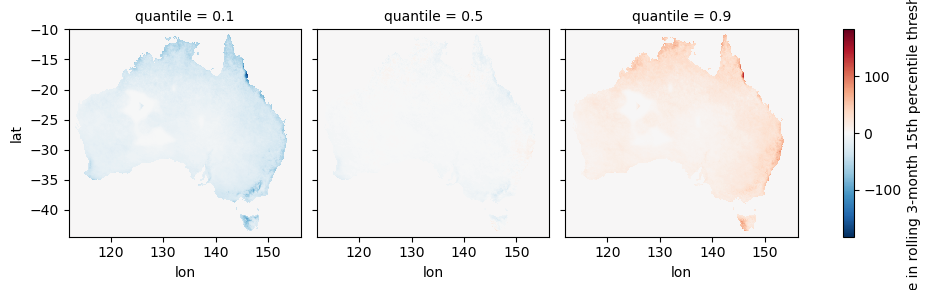

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

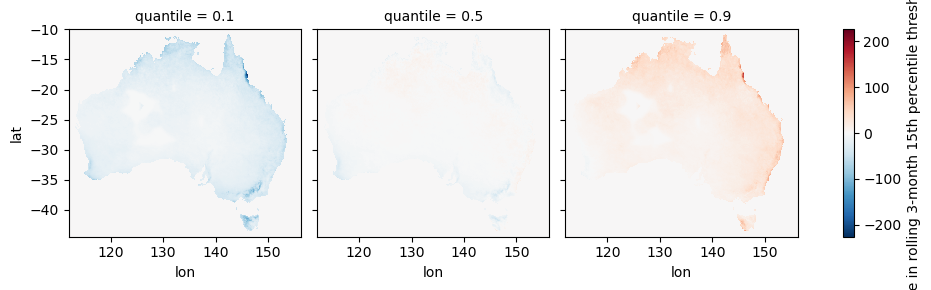

<Figure size 640x480 with 0 Axes>

In [11]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc")
    (quick_check_ds.p15_3month.mean(dim='month')).plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in rolling 3-month 15th percentile threshold (mm)'})
    plt.show()
    plt.clf()